In [1]:
import os
import joblib
import numpy as np
from qsc import Qsc
import pandas as pd
from keras.models import load_model

params = {'results_path': 'results',
          'data_path': 'data',
          'nfp': 3,
          'model': 'nn',
          'best_points': False,
          }

model_path = os.path.join(params['results_path'], f"nfp{params['nfp']}", f"nn_qsc_nfp{params['nfp']}_model{params['model']}"+("_best" if params['best_points'] else "")+".h5")
scaler_x_path = os.path.join(params['results_path'], f"nfp{params['nfp']}", f"nn_qsc_nfp{params['nfp']}_scaler_x"+("_best" if params['best_points'] else "")+".pkl")
scaler_y_path = os.path.join(params['results_path'], f"nfp{params['nfp']}", f"nn_qsc_nfp{params['nfp']}_scaler_y"+("_best" if params['best_points'] else "")+".pkl")

model = load_model(model_path)
scaler_x = joblib.load(scaler_x_path)
scaler_y = joblib.load(scaler_y_path)

In [28]:
filename = os.path.join(params['data_path'], f'qsc_out.random_scan_nfp{params["nfp"]}'+("_best" if params['best_points'] else "")+'.parquet')
df = pd.read_parquet(filename)
df.loc[:, df.columns.str.startswith('y')].head(20)

,y0,y1,y2,y3,y4,y5,y6,y7,y8,y9,y10,y11
0,0.029843,0.037057,0.182455,0.687687,0.194387,0.977707,15.997072,33.912338,1.172316,0.022942,0.015956,0
1,0.048864,0.035815,1.146545,0.697980,0.161539,0.983498,2.514961,-2161.641357,1.187292,0.018712,0.011281,0
2,0.038568,0.036271,0.581099,0.563505,0.151736,0.968331,22.412334,20.990492,1.291036,0.029106,0.022592,0
3,0.153407,0.080160,4.982504,0.363623,0.202438,0.986242,3.230772,-556.242004,1.227968,0.053826,0.009616,0
4,1.791213,0.060902,11.284778,0.212454,0.096343,0.662911,4.175532,-187.002350,2.008304,0.211608,0.241206,-1
5,0.427346,0.040568,9.693456,0.231517,0.142567,0.972616,9.030353,-825.236938,1.505798,0.075583,0.018935,0
6,2.343931,0.052022,10.317529,0.168190,0.085024,0.576758,14.046102,-4340.854004,3.837461,0.194946,0.247682,-1
7,0.413411,0.033780,5.582307,0.288351,0.165770,0.974070,8.557347,-785.115234,1.581078,0.093741,0.018756,0
8,0.018738,0.050949,0.397689,0.706643,0.190954,0.970712,11.063989,-27.428690,1.222266,0.008452,0.021533,0
9,2.567565,0.045222,4.385195,0.220798,0.117005,0.479124,22.138561,-242.929153,2.979518,0.271892,0.352451,-1


In [3]:
def make_prediction(model, scaler, input_data):
    input_data = np.array(input_data)
    input_data_scaled = scaler.transform(input_data.reshape(1, -1))
    prediction = model.predict(input_data_scaled)
    prediction = scaler_y.inverse_transform(prediction)[0]
    return prediction

In [58]:
##          y = [iota,   r_singularity, B20_variation, L_grad_B, L_grad_grad_B, min_R0, elongation, d2_volume_d_psi2, curvature, standard_deviation_of_Z, standard_deviation_of_R, helicity]
#input_Y_date = [0.029843	0.037057	0.182455	0.687687	0.194387	0.977707	15.997072	33.912338	1.172316	0.022942	0.015956	0]
input_Y_data = [2.1, 0.08, 5.0, 0.3, 0.3, 0.5, 10.0, 2., 1.8, 0.4, 0.4, -1]
prediction = make_prediction(model, scaler_x, input_Y_data)
prediction

1/1 [==============================] - 0s 10ms/step


array([ 5.3793484e-01, -5.4740751e-01,  5.8786910e-02, -6.3970932e-03,
        1.9057596e-02, -7.8065455e-04, -7.1824193e-01,  1.2095127e+00],
      dtype=float32)

In [59]:
# Print the results
n_axis_fourier_modes = int((len(prediction)-2)/2)
predicted_rc = np.append([1],prediction[0:2*n_axis_fourier_modes:2])
predicted_zs = np.append([0],prediction[1:2*n_axis_fourier_modes+1:2])
predicted_eta_bar = prediction[2*n_axis_fourier_modes]
predicted_B2c = prediction[2*n_axis_fourier_modes+1]
stel = Qsc(rc=predicted_rc, zs=predicted_zs, etabar=predicted_eta_bar, nfp=int(params['nfp']), B2c=predicted_B2c, order='r3', nphi=151)
print('------------------------------------------')
print(f'  predicted_rc      = {", ".join(["{:.3e}".format(i) for i in predicted_rc])}')
print(f'  predicted_zs      = {", ".join(["{:.3e}".format(i) for i in predicted_zs])}')
print(f'  predicted_etabar  = {predicted_eta_bar:.3e}')
print(f'  predicted_B2c     = {predicted_B2c:.3e}')
print('------------------------------------------')
print(f'  predicted_iota          = {stel.iota:.3e}')
print(f'  asked_iota              = {input_Y_data[0]:.3e}')
print(f'  predicted_r_singularity = {stel.r_singularity:.3e}')
print(f'  asked_r_singularity     = {input_Y_data[1]:.3e}')
print(f'  predicted_B20_variation = {stel.B20_variation:.3e}')
print(f'  asked_B20_variation     = {input_Y_data[2]:.3e}')
print(f'  predicted_L_gradB       = {stel.min_L_grad_B:.3e}')
print(f'  asked_L_gradB           = {input_Y_data[3]:.3e}')
print(f'  predicted_L_gradgradB   = {1/stel.grad_grad_B_inverse_scale_length:.3e}')
print(f'  asked_L_gradgradB       = {input_Y_data[4]:.3e}')
print(f'  predicted_min_R0        = {stel.min_R0:.3e}')
print(f'  asked_min_R0            = {input_Y_data[5]:.3e}')
print(f'  predicted_elongation    = {stel.max_elongation:.3e}')
print(f'  asked_elongation        = {input_Y_data[6]:.3e}')
print(f'  predicted_d2_volume_d_psi2 = {stel.d2_volume_d_psi2:.3e}')
print(f'  asked_d2_volume_d_psi2     = {input_Y_data[7]:.3e}')
print(f'  predicted_helicity      = {stel.helicity:.3e}')
print(f'  asked_helicity          = {input_Y_data[11]:.3e}')

------------------------------------------
  predicted_rc      = 1.000e+00, 5.379e-01, 5.879e-02, 1.906e-02
  predicted_zs      = 0.000e+00, -5.474e-01, -6.397e-03, -7.807e-04
  predicted_etabar  = -7.182e-01
  predicted_B2c     = 1.210e+00
------------------------------------------
  predicted_iota          = 2.160e+00
  asked_iota              = 2.100e+00
  predicted_r_singularity = 4.817e-02
  asked_r_singularity     = 8.000e-02
  predicted_B20_variation = 5.124e+00
  asked_B20_variation     = 5.000e+00
  predicted_L_gradB       = 3.424e-01
  asked_L_gradB           = 3.000e-01
  predicted_L_gradgradB   = 1.568e-01
  asked_L_gradgradB       = 3.000e-01
  predicted_min_R0        = 5.018e-01
  asked_min_R0            = 5.000e-01
  predicted_elongation    = 9.912e+00
  asked_elongation        = 1.000e+01
  predicted_d2_volume_d_psi2 = 3.818e+02
  asked_d2_volume_d_psi2     = 2.000e+00
  predicted_helicity      = -1.000e+00
  asked_helicity          = -1.000e+00


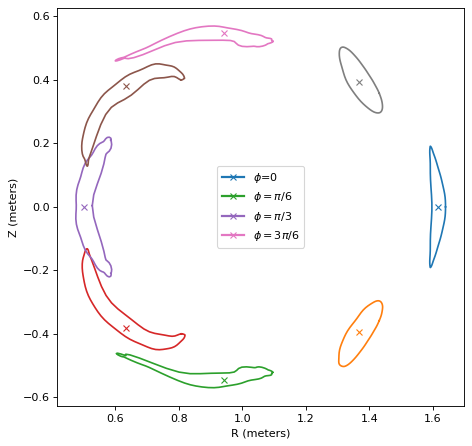

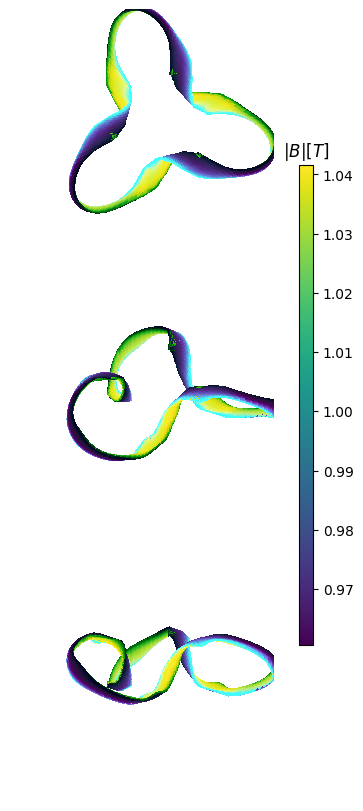

In [60]:
stel.plot_boundary(r=stel.r_singularity)